<a href="https://colab.research.google.com/github/Nehil971/Satge_L3/blob/master/D%C3%A9but_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U bindsnet

     |████████████████████████████████| 71kB 4.7MB/s 
     |████████████████████████████████| 204kB 11.9MB/s 
  Created wheel for bindsnet: filename=bindsnet-0.2.6-cp36-none-any.whl size=81415 sha256=89a9eb95c6419744c0b721a0dee756b766b956548c53712452cf8814bb886ac6
  Stored in directory: /root/.cache/pip/wheels/92/6c/2f/f29fa692e20be42b2f42b0d0434980c8e528f62d24ee7ed5c1
Successfully built bindsnet


In [0]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from bindsnet.models import DiehlAndCook2015v2
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.datasets import MNIST, DataLoader
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
from tqdm import tqdm
from bindsnet.utils import get_square_weights
from bindsnet import ROOT_DIR

In [0]:
import glob
from bindsnet import encoding
from PIL import Image
from numpy import max

In [0]:
def single(
        datum: torch.Tensor, time: int, dt: float = 1.0, min : float = 0, max : float = 255.0, **kwargs
) -> torch.Tensor:
    # language=rst
    """
    Generates timing based single-spike encoding. Spike occurs earlier if the
    intensity of the input feature is higher. Features whose value is lower than
    threshold is remain silent.

    :param datum: Tensor of shape ``[n_1, ..., n_k]``.
    :param time: Length of the input and output.
    :param dt: Simulation time step.
    :param sparsity: Sparsity of the input representation. 0 for no spikes and 1 for all
        spikes.
    :return: Tensor of shape ``[time, n_1, ..., n_k]``.
    """
    # [Min, Max] découpé en time intervals
    time = int(time / dt)
    shape = list(datum.shape)
    datum = np.copy(datum)
    s = np.zeros([time, *shape])
    s[0] = np.zeros(shape)
    dv = np.float((max-min)/time)
    v = np.float(max)-dv
    for t in range(time):
        mask = (datum >= v)
        #s[t] = np.where((v - dv) < datum <= v, np.ones(shape), np.zeros(shape))
        s[t] = np.where(mask, np.ones(shape), np.zeros(shape))
        v -= dv
        datum[mask] = min-1

    return torch.Tensor(s).byte()

def normalisation(data : torch.Tensor ,min : float = 0.0, max : float = 255.0):
    min2 = torch.min(data)
    max2 = torch.max(data)
    data = (data - min2) / (max2 - min2) * (max-min) + min

    return data

def LoadImg(Chemin : str, bandes : int, length : int, width : int):
  assert bandes == 1 or bandes == 3

  images = glob.glob(Chemin+"/*jpg")

  imtens = torch.Tensor(len(images), bandes, length, width)
  i =0
  for image in images :
    img = Image.open(image)

    ## Modification img si besoin
    if img.height != length or img.width != width:
      img = transforms.Resize((length,width))(img)

    img = transforms.Grayscale(bandes)(img)
    imtens[i] = transforms.ToTensor()(img)*255

    ## Modification du bandes, de 3 vers 1:
    #if imtens[i].size(0) > bandes:
      #img = transforms.Grayscale(1)(img)
      #imtens[i] = transforms.ToTensor()(img)*255

    ## Modification du bandes, de 1 vers 3:
    #if imtens[i].size(0) < bandes:
      #img = transforms.Grayscale(3)(img)
      #imtens[i] = transforms.ToTensor()(img)*255
    i +=1
  return imtens


In [0]:
batch_size = 32
update_steps = 256
time = 250
dt = 1.0
seed = 0
plot = True
gpu = False
n_neurons = 30
n_workers = 0
intensity = 128
n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
update_interval = update_steps * batch_size

0it [00:00, ?it/s]

9920512it [00:01, 8627989.30it/s]                            


Extracting /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz to /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130930.40it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz to /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw


1654784it [00:00, 2146873.86it/s]                            
0it [00:00, ?it/s]

Extracting /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz to /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw


8192it [00:00, 48667.98it/s]            


Extracting /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz to /usr/local/lib/python3.6/dist-packages/data/MNIST/TorchvisionDatasetWrapper/raw
Processing...
Done!


  0%|          | 0/1875 [00:00<?, ?it/s]

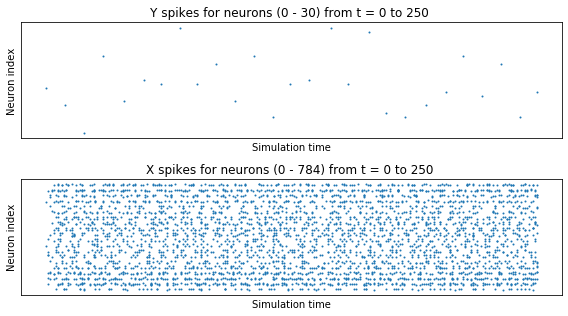

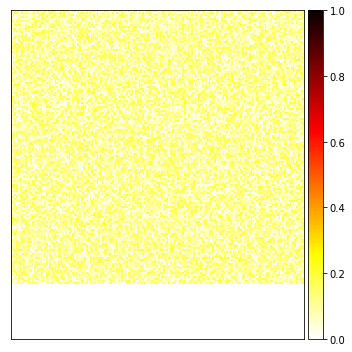

  0%|          | 1/1875 [00:01<59:24,  1.90s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 2/1875 [00:03<53:08,  1.70s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 3/1875 [00:04<49:03,  1.57s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 4/1875 [00:05<46:47,  1.50s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 5/1875 [00:06<44:14,  1.42s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 6/1875 [00:08<42:35,  1.37s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 7/1875 [00:09<41:51,  1.34s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 8/1875 [00:10<40:57,  1.32s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 9/1875 [00:11<40:00,  1.29s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 10/1875 [00:13<39:50,  1.28s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 11/1875 [00:14<39:47,  1.28s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 12/1875 [00:15<39:21,  1.27s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 13/1875 [00:17<39:14,  1.26s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 14/1875 [00:18<39:09,  1.26s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 15/1875 [00:19<39:08,  1.26s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 16/1875 [00:20<39:11,  1.26s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 17/1875 [00:22<39:10,  1.27s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 18/1875 [00:23<38:56,  1.26s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 19/1875 [00:24<38:42,  1.25s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 20/1875 [00:25<38:34,  1.25s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 21/1875 [00:27<38:37,  1.25s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 22/1875 [00:28<38:32,  1.25s/it]

<Figure size 432x288 with 0 Axes>

  1%|          | 23/1875 [00:29<38:10,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  1%|▏         | 24/1875 [00:30<38:01,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  1%|▏         | 25/1875 [00:31<37:51,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  1%|▏         | 26/1875 [00:33<37:58,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  1%|▏         | 27/1875 [00:34<37:51,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  1%|▏         | 28/1875 [00:35<37:50,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 29/1875 [00:36<38:05,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 30/1875 [00:38<37:50,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 31/1875 [00:39<37:57,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 32/1875 [00:40<38:09,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 33/1875 [00:41<37:41,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 34/1875 [00:43<37:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 35/1875 [00:44<37:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 36/1875 [00:45<37:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 37/1875 [00:46<37:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 38/1875 [00:47<37:54,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 39/1875 [00:49<38:05,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 40/1875 [00:50<37:41,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 41/1875 [00:51<38:02,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 42/1875 [00:52<37:55,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 43/1875 [00:54<37:55,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 44/1875 [00:55<37:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 45/1875 [00:56<37:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  2%|▏         | 46/1875 [00:57<37:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 47/1875 [00:59<37:09,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 48/1875 [01:00<36:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 49/1875 [01:01<36:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 50/1875 [01:02<37:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 51/1875 [01:03<37:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 52/1875 [01:05<36:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 53/1875 [01:06<36:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 54/1875 [01:07<37:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 55/1875 [01:08<37:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 56/1875 [01:09<37:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 57/1875 [01:11<37:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 58/1875 [01:12<37:37,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 59/1875 [01:13<37:25,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 60/1875 [01:14<37:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 61/1875 [01:16<36:51,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 62/1875 [01:17<36:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 63/1875 [01:18<37:12,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 64/1875 [01:19<36:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  3%|▎         | 65/1875 [01:21<37:17,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  4%|▎         | 66/1875 [01:22<37:05,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  4%|▎         | 67/1875 [01:23<37:15,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  4%|▎         | 68/1875 [01:24<37:03,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  4%|▎         | 69/1875 [01:25<36:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▎         | 70/1875 [01:27<36:51,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 71/1875 [01:28<36:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 72/1875 [01:29<36:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 73/1875 [01:30<36:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 74/1875 [01:32<36:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 75/1875 [01:33<36:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 76/1875 [01:34<36:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 77/1875 [01:35<36:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 78/1875 [01:36<36:29,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 79/1875 [01:38<36:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 80/1875 [01:39<36:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 81/1875 [01:40<36:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 82/1875 [01:41<36:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 83/1875 [01:42<36:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  4%|▍         | 84/1875 [01:44<36:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 85/1875 [01:45<36:26,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 86/1875 [01:46<36:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 87/1875 [01:47<36:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 88/1875 [01:49<36:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 89/1875 [01:50<36:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 90/1875 [01:51<36:30,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 91/1875 [01:52<36:27,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 92/1875 [01:54<36:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▍         | 93/1875 [01:55<35:53,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 94/1875 [01:56<36:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 95/1875 [01:57<36:09,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 96/1875 [01:58<36:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 97/1875 [02:00<36:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 98/1875 [02:01<35:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 99/1875 [02:02<36:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 100/1875 [02:03<36:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 101/1875 [02:04<36:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 102/1875 [02:06<36:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  5%|▌         | 103/1875 [02:07<36:17,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 104/1875 [02:08<36:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 105/1875 [02:09<35:53,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 106/1875 [02:11<35:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 107/1875 [02:12<35:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 108/1875 [02:13<35:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 109/1875 [02:14<35:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 110/1875 [02:15<35:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 111/1875 [02:17<36:15,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 112/1875 [02:18<36:17,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 113/1875 [02:19<35:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 114/1875 [02:20<35:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 115/1875 [02:22<35:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 116/1875 [02:23<35:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▌         | 117/1875 [02:24<35:26,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  6%|▋         | 118/1875 [02:25<35:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  6%|▋         | 119/1875 [02:26<35:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  6%|▋         | 120/1875 [02:28<35:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  6%|▋         | 121/1875 [02:29<35:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 122/1875 [02:30<35:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 123/1875 [02:31<35:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 124/1875 [02:32<35:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 125/1875 [02:34<35:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 126/1875 [02:35<35:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 127/1875 [02:36<35:20,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 128/1875 [02:37<35:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 129/1875 [02:39<35:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 130/1875 [02:40<35:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 131/1875 [02:41<35:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 132/1875 [02:42<35:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 133/1875 [02:43<35:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 134/1875 [02:45<35:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 135/1875 [02:46<35:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 136/1875 [02:47<34:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 137/1875 [02:48<35:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 138/1875 [02:49<35:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 139/1875 [02:51<35:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  7%|▋         | 140/1875 [02:52<35:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 141/1875 [02:53<35:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 142/1875 [02:54<35:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 143/1875 [02:56<35:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 144/1875 [02:57<35:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 145/1875 [02:58<34:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 146/1875 [02:59<34:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 147/1875 [03:00<34:53,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 148/1875 [03:02<35:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 149/1875 [03:03<35:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 150/1875 [03:04<35:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 151/1875 [03:05<35:11,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 152/1875 [03:07<35:20,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 153/1875 [03:08<34:56,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 154/1875 [03:09<34:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 155/1875 [03:10<34:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 156/1875 [03:11<34:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 157/1875 [03:13<34:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 158/1875 [03:14<34:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  8%|▊         | 159/1875 [03:15<34:25,  1.20s/it]

<Figure size 432x288 with 0 Axes>

  9%|▊         | 160/1875 [03:16<34:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

  9%|▊         | 161/1875 [03:17<34:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

  9%|▊         | 162/1875 [03:19<34:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▊         | 163/1875 [03:20<34:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▊         | 164/1875 [03:21<34:41,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 165/1875 [03:22<35:16,  1.24s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 166/1875 [03:24<35:03,  1.23s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 167/1875 [03:25<34:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 168/1875 [03:26<34:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 169/1875 [03:27<34:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 170/1875 [03:28<34:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 171/1875 [03:30<34:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 172/1875 [03:31<34:09,  1.20s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 173/1875 [03:32<34:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 174/1875 [03:33<34:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 175/1875 [03:34<34:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 176/1875 [03:36<34:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 177/1875 [03:37<34:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

  9%|▉         | 178/1875 [03:38<33:57,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 179/1875 [03:39<33:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 180/1875 [03:40<33:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 181/1875 [03:42<33:44,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 182/1875 [03:43<33:56,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 183/1875 [03:44<33:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 184/1875 [03:45<34:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 185/1875 [03:46<34:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 186/1875 [03:48<34:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|▉         | 187/1875 [03:49<34:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 188/1875 [03:50<34:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 189/1875 [03:51<34:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 190/1875 [03:53<34:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 191/1875 [03:54<34:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 192/1875 [03:55<34:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 193/1875 [03:56<33:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 194/1875 [03:57<33:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 195/1875 [03:59<33:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 10%|█         | 196/1875 [04:00<33:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 197/1875 [04:01<33:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 198/1875 [04:02<34:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 199/1875 [04:03<33:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 200/1875 [04:05<34:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 201/1875 [04:06<33:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 202/1875 [04:07<33:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 203/1875 [04:08<33:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 204/1875 [04:09<33:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 205/1875 [04:11<33:17,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 206/1875 [04:12<33:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 207/1875 [04:13<33:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 208/1875 [04:14<33:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 209/1875 [04:15<33:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 11%|█         | 210/1875 [04:17<33:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█▏        | 211/1875 [04:18<33:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█▏        | 212/1875 [04:19<33:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█▏        | 213/1875 [04:20<33:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█▏        | 214/1875 [04:22<33:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 11%|█▏        | 215/1875 [04:23<34:00,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 216/1875 [04:24<33:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 217/1875 [04:25<33:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 218/1875 [04:26<33:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 219/1875 [04:28<34:11,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 220/1875 [04:29<34:02,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 221/1875 [04:30<33:50,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 222/1875 [04:31<33:48,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 223/1875 [04:33<33:44,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 224/1875 [04:34<33:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 225/1875 [04:35<33:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 226/1875 [04:36<33:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 227/1875 [04:37<33:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 228/1875 [04:39<33:01,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 229/1875 [04:40<32:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 230/1875 [04:41<33:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 231/1875 [04:42<33:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 232/1875 [04:43<33:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 233/1875 [04:45<33:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 12%|█▏        | 234/1875 [04:46<33:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 235/1875 [04:47<33:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 236/1875 [04:48<32:51,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 237/1875 [04:49<32:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 238/1875 [04:51<32:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 239/1875 [04:52<32:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 240/1875 [04:53<32:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 241/1875 [04:54<32:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 242/1875 [04:55<32:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 243/1875 [04:57<32:35,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 244/1875 [04:58<32:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 245/1875 [04:59<32:27,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 246/1875 [05:00<32:27,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 247/1875 [05:01<32:24,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 248/1875 [05:03<32:27,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 249/1875 [05:04<32:34,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 250/1875 [05:05<32:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 251/1875 [05:06<32:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 252/1875 [05:08<32:53,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 13%|█▎        | 253/1875 [05:09<33:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▎        | 254/1875 [05:10<33:12,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▎        | 255/1875 [05:11<33:15,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▎        | 256/1875 [05:12<32:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▎        | 257/1875 [05:14<32:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 258/1875 [05:15<32:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 259/1875 [05:16<32:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 260/1875 [05:17<32:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 261/1875 [05:19<32:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 262/1875 [05:20<32:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 263/1875 [05:21<32:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 264/1875 [05:22<32:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 265/1875 [05:23<32:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 266/1875 [05:25<32:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 267/1875 [05:26<32:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 268/1875 [05:27<32:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 269/1875 [05:28<32:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 270/1875 [05:29<32:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 14%|█▍        | 271/1875 [05:31<32:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 272/1875 [05:32<32:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 273/1875 [05:33<32:49,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 274/1875 [05:34<32:42,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 275/1875 [05:36<32:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 276/1875 [05:37<32:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 277/1875 [05:38<32:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 278/1875 [05:39<32:03,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 279/1875 [05:40<31:56,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 280/1875 [05:42<32:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▍        | 281/1875 [05:43<32:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 282/1875 [05:44<32:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 283/1875 [05:45<31:51,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 284/1875 [05:46<31:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 285/1875 [05:48<32:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 286/1875 [05:49<32:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 287/1875 [05:50<31:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 288/1875 [05:51<31:47,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 289/1875 [05:52<31:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 15%|█▌        | 290/1875 [05:54<31:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 291/1875 [05:55<31:20,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 292/1875 [05:56<31:19,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 293/1875 [05:57<31:25,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 294/1875 [05:58<31:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 295/1875 [06:00<31:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 296/1875 [06:01<31:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 297/1875 [06:02<31:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 298/1875 [06:03<31:33,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 299/1875 [06:04<31:26,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 300/1875 [06:06<31:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 301/1875 [06:07<31:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 302/1875 [06:08<31:17,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 303/1875 [06:09<31:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▌        | 304/1875 [06:10<31:04,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▋        | 305/1875 [06:11<30:59,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▋        | 306/1875 [06:13<31:02,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▋        | 307/1875 [06:14<31:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▋        | 308/1875 [06:15<31:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 16%|█▋        | 309/1875 [06:16<31:25,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 310/1875 [06:18<31:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 311/1875 [06:19<31:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 312/1875 [06:20<31:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 313/1875 [06:21<31:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 314/1875 [06:22<31:26,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 315/1875 [06:24<31:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 316/1875 [06:25<31:21,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 317/1875 [06:26<31:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 318/1875 [06:27<31:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 319/1875 [06:28<31:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 320/1875 [06:30<31:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 321/1875 [06:31<31:05,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 322/1875 [06:32<31:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 323/1875 [06:33<31:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 324/1875 [06:34<30:49,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 325/1875 [06:36<30:54,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 326/1875 [06:37<30:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 327/1875 [06:38<31:40,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 17%|█▋        | 328/1875 [06:39<31:43,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 329/1875 [06:41<31:44,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 330/1875 [06:42<31:41,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 331/1875 [06:43<31:33,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 332/1875 [06:44<31:38,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 333/1875 [06:45<31:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 334/1875 [06:47<31:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 335/1875 [06:48<31:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 336/1875 [06:49<31:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 337/1875 [06:50<31:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 338/1875 [06:51<31:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 339/1875 [06:53<31:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 340/1875 [06:54<31:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 341/1875 [06:55<31:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 342/1875 [06:56<31:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 343/1875 [06:58<31:20,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 344/1875 [06:59<31:25,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 345/1875 [07:00<31:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 18%|█▊        | 346/1875 [07:01<31:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▊        | 347/1875 [07:03<31:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▊        | 348/1875 [07:04<31:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▊        | 349/1875 [07:05<30:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▊        | 350/1875 [07:06<31:10,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▊        | 351/1875 [07:07<31:11,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 352/1875 [07:09<31:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 353/1875 [07:10<31:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 354/1875 [07:11<31:06,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 355/1875 [07:12<30:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 356/1875 [07:14<30:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 357/1875 [07:15<30:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 358/1875 [07:16<30:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 359/1875 [07:17<30:42,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 360/1875 [07:18<31:13,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 361/1875 [07:20<31:08,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 362/1875 [07:21<31:10,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 363/1875 [07:22<31:01,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 364/1875 [07:23<30:55,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 19%|█▉        | 365/1875 [07:25<30:39,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 366/1875 [07:26<30:41,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 367/1875 [07:27<30:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 368/1875 [07:28<30:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 369/1875 [07:29<30:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 370/1875 [07:31<30:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 371/1875 [07:32<29:58,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 372/1875 [07:33<29:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 373/1875 [07:34<29:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 20%|█▉        | 374/1875 [07:35<29:55,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 375/1875 [07:37<29:41,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 376/1875 [07:38<29:35,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 377/1875 [07:39<29:55,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 378/1875 [07:40<30:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 379/1875 [07:41<30:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 380/1875 [07:43<31:02,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 381/1875 [07:44<30:41,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 382/1875 [07:45<30:39,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 383/1875 [07:46<30:16,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 20%|██        | 384/1875 [07:48<30:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 385/1875 [07:49<30:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 386/1875 [07:50<30:24,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 387/1875 [07:51<30:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 388/1875 [07:52<30:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 389/1875 [07:54<30:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 390/1875 [07:55<30:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 391/1875 [07:56<30:26,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 392/1875 [07:57<30:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 393/1875 [07:59<30:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 394/1875 [08:00<30:20,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 395/1875 [08:01<29:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 396/1875 [08:02<29:58,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 397/1875 [08:03<29:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 21%|██        | 398/1875 [08:05<29:56,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██▏       | 399/1875 [08:06<29:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 21%|██▏       | 400/1875 [08:07<29:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 21%|██▏       | 401/1875 [08:08<29:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 21%|██▏       | 402/1875 [08:09<29:53,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 21%|██▏       | 403/1875 [08:11<29:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 404/1875 [08:12<29:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 405/1875 [08:13<29:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 406/1875 [08:14<29:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 407/1875 [08:16<29:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 408/1875 [08:17<29:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 409/1875 [08:18<30:01,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 410/1875 [08:19<30:06,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 411/1875 [08:20<30:07,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 412/1875 [08:22<29:58,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 413/1875 [08:23<30:26,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 414/1875 [08:24<30:13,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 415/1875 [08:25<29:57,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 416/1875 [08:27<30:06,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 417/1875 [08:28<29:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 418/1875 [08:29<29:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 419/1875 [08:30<29:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 420/1875 [08:32<29:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 22%|██▏       | 421/1875 [08:33<29:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 422/1875 [08:34<29:09,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 423/1875 [08:35<29:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 424/1875 [08:36<29:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 425/1875 [08:38<29:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 426/1875 [08:39<29:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 427/1875 [08:40<29:00,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 428/1875 [08:41<29:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 429/1875 [08:42<29:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 430/1875 [08:44<29:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 431/1875 [08:45<29:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 432/1875 [08:46<29:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 433/1875 [08:47<29:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 434/1875 [08:48<29:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 435/1875 [08:50<29:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 436/1875 [08:51<29:11,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 437/1875 [08:52<29:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 438/1875 [08:53<29:14,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 439/1875 [08:55<28:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 23%|██▎       | 440/1875 [08:56<28:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▎       | 441/1875 [08:57<28:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▎       | 442/1875 [08:58<28:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▎       | 443/1875 [08:59<28:34,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▎       | 444/1875 [09:01<28:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▎       | 445/1875 [09:02<28:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 446/1875 [09:03<28:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 447/1875 [09:04<28:34,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 448/1875 [09:05<28:24,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 449/1875 [09:07<28:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 450/1875 [09:08<28:20,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 451/1875 [09:09<28:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 452/1875 [09:10<28:18,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 453/1875 [09:11<28:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 454/1875 [09:12<28:09,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 455/1875 [09:14<28:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 456/1875 [09:15<28:19,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 457/1875 [09:16<28:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 458/1875 [09:17<28:18,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 24%|██▍       | 459/1875 [09:19<28:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 460/1875 [09:20<28:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 461/1875 [09:21<28:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 462/1875 [09:22<28:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 463/1875 [09:23<28:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 464/1875 [09:25<28:53,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 465/1875 [09:26<28:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 466/1875 [09:27<28:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 467/1875 [09:28<28:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▍       | 468/1875 [09:29<28:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 469/1875 [09:31<28:39,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 470/1875 [09:32<29:00,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 471/1875 [09:33<29:02,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 472/1875 [09:34<29:06,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 473/1875 [09:36<28:55,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 474/1875 [09:37<28:46,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 475/1875 [09:38<28:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 476/1875 [09:39<28:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 477/1875 [09:40<28:01,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 25%|██▌       | 478/1875 [09:42<27:55,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 479/1875 [09:43<28:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 480/1875 [09:44<28:00,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 481/1875 [09:45<28:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 482/1875 [09:47<28:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 483/1875 [09:48<28:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 484/1875 [09:49<28:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 485/1875 [09:50<28:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 486/1875 [09:52<28:54,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 487/1875 [09:53<28:40,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 488/1875 [09:54<28:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 489/1875 [09:55<28:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 490/1875 [09:56<28:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 491/1875 [09:58<27:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▌       | 492/1875 [09:59<27:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▋       | 493/1875 [10:00<27:34,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▋       | 494/1875 [10:01<27:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▋       | 495/1875 [10:02<27:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 26%|██▋       | 496/1875 [10:04<27:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 497/1875 [10:05<27:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 498/1875 [10:06<27:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 499/1875 [10:07<27:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 500/1875 [10:08<27:41,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 501/1875 [10:10<27:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 502/1875 [10:11<27:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 503/1875 [10:12<27:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 504/1875 [10:13<27:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 505/1875 [10:14<27:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 506/1875 [10:16<27:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 507/1875 [10:17<27:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 508/1875 [10:18<27:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 509/1875 [10:19<27:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 510/1875 [10:20<27:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 511/1875 [10:22<27:06,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 512/1875 [10:23<27:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 513/1875 [10:24<27:16,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 514/1875 [10:25<27:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 27%|██▋       | 515/1875 [10:26<27:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 516/1875 [10:28<27:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 517/1875 [10:29<27:41,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 518/1875 [10:30<27:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 519/1875 [10:31<27:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 520/1875 [10:33<27:21,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 521/1875 [10:34<27:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 522/1875 [10:35<27:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 523/1875 [10:36<27:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 524/1875 [10:37<27:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 525/1875 [10:39<27:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 526/1875 [10:40<27:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 527/1875 [10:41<27:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 528/1875 [10:42<27:30,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 529/1875 [10:44<27:30,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 530/1875 [10:45<27:16,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 531/1875 [10:46<27:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 532/1875 [10:47<26:45,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 533/1875 [10:48<26:39,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 28%|██▊       | 534/1875 [10:49<26:39,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▊       | 535/1875 [10:51<26:45,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▊       | 536/1875 [10:52<26:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▊       | 537/1875 [10:53<27:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▊       | 538/1875 [10:54<27:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▊       | 539/1875 [10:56<26:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 540/1875 [10:57<27:30,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 541/1875 [10:58<27:22,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 542/1875 [10:59<27:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 543/1875 [11:00<26:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 544/1875 [11:02<26:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 545/1875 [11:03<27:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 546/1875 [11:04<26:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 547/1875 [11:05<26:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 548/1875 [11:06<26:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 549/1875 [11:08<26:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 550/1875 [11:09<26:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 551/1875 [11:10<26:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 552/1875 [11:11<26:21,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 29%|██▉       | 553/1875 [11:12<26:22,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 554/1875 [11:14<26:16,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 555/1875 [11:15<26:11,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 556/1875 [11:16<26:11,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 557/1875 [11:17<26:06,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 558/1875 [11:18<26:09,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 559/1875 [11:20<26:00,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 560/1875 [11:21<26:03,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 561/1875 [11:22<26:05,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|██▉       | 562/1875 [11:23<25:57,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 563/1875 [11:24<26:04,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 564/1875 [11:26<26:03,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 565/1875 [11:27<26:11,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 566/1875 [11:28<26:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 567/1875 [11:29<26:10,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 568/1875 [11:30<26:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 569/1875 [11:32<25:53,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 570/1875 [11:33<26:05,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 30%|███       | 571/1875 [11:34<26:11,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 572/1875 [11:35<26:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 573/1875 [11:36<26:21,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 574/1875 [11:38<26:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 575/1875 [11:39<26:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 576/1875 [11:40<26:37,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 577/1875 [11:41<26:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 578/1875 [11:43<26:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 579/1875 [11:44<26:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 580/1875 [11:45<26:32,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 581/1875 [11:46<26:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 582/1875 [11:47<25:51,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 583/1875 [11:49<25:51,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 584/1875 [11:50<25:40,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 31%|███       | 585/1875 [11:51<25:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 31%|███▏      | 586/1875 [11:52<25:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███▏      | 587/1875 [11:53<25:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███▏      | 588/1875 [11:55<25:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███▏      | 589/1875 [11:56<25:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 31%|███▏      | 590/1875 [11:57<25:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 591/1875 [11:58<25:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 592/1875 [11:59<25:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 593/1875 [12:01<26:20,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 594/1875 [12:02<26:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 595/1875 [12:03<26:09,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 596/1875 [12:04<26:11,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 597/1875 [12:06<26:08,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 598/1875 [12:07<26:12,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 599/1875 [12:08<26:07,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 600/1875 [12:09<26:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 601/1875 [12:10<25:53,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 602/1875 [12:12<25:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 603/1875 [12:13<25:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 604/1875 [12:14<25:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 605/1875 [12:15<25:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 606/1875 [12:17<25:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 607/1875 [12:18<25:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 608/1875 [12:19<25:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 32%|███▏      | 609/1875 [12:20<25:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 610/1875 [12:21<25:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 611/1875 [12:23<25:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 612/1875 [12:24<25:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 613/1875 [12:25<25:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 614/1875 [12:26<25:20,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 615/1875 [12:27<25:17,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 616/1875 [12:29<25:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 617/1875 [12:30<25:07,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 618/1875 [12:31<25:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 619/1875 [12:32<25:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 620/1875 [12:33<25:05,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 621/1875 [12:35<25:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 622/1875 [12:36<25:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 623/1875 [12:37<25:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 624/1875 [12:38<25:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 625/1875 [12:39<25:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 626/1875 [12:41<25:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 627/1875 [12:42<25:18,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 33%|███▎      | 628/1875 [12:43<25:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▎      | 629/1875 [12:44<25:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▎      | 630/1875 [12:46<25:16,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▎      | 631/1875 [12:47<25:11,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▎      | 632/1875 [12:48<25:11,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 633/1875 [12:49<25:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 634/1875 [12:50<25:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 635/1875 [12:52<24:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 636/1875 [12:53<24:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 637/1875 [12:54<24:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 638/1875 [12:55<24:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 639/1875 [12:56<24:45,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 640/1875 [12:58<24:44,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 641/1875 [12:59<24:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 642/1875 [13:00<25:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 643/1875 [13:01<24:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 644/1875 [13:02<24:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 645/1875 [13:04<24:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 34%|███▍      | 646/1875 [13:05<25:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 647/1875 [13:06<24:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 648/1875 [13:07<24:50,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 649/1875 [13:09<24:51,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 650/1875 [13:10<25:06,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 651/1875 [13:11<24:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 652/1875 [13:12<24:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 653/1875 [13:13<24:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 654/1875 [13:15<24:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 655/1875 [13:16<24:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▍      | 656/1875 [13:17<24:53,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 657/1875 [13:18<25:02,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 658/1875 [13:20<24:54,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 659/1875 [13:21<24:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 660/1875 [13:22<24:52,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 661/1875 [13:23<24:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 662/1875 [13:24<24:50,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 663/1875 [13:26<24:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 664/1875 [13:27<24:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 35%|███▌      | 665/1875 [13:28<24:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 666/1875 [13:29<24:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 667/1875 [13:31<24:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 668/1875 [13:32<24:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 669/1875 [13:33<24:38,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 670/1875 [13:34<24:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 671/1875 [13:35<24:21,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 672/1875 [13:37<24:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 673/1875 [13:38<24:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 674/1875 [13:39<24:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 675/1875 [13:40<24:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 676/1875 [13:42<24:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 677/1875 [13:43<24:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 678/1875 [13:44<24:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▌      | 679/1875 [13:45<24:18,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▋      | 680/1875 [13:46<24:27,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▋      | 681/1875 [13:48<24:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▋      | 682/1875 [13:49<24:25,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▋      | 683/1875 [13:50<24:22,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 36%|███▋      | 684/1875 [13:51<24:20,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 685/1875 [13:53<24:26,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 686/1875 [13:54<24:18,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 687/1875 [13:55<24:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 688/1875 [13:56<24:18,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 689/1875 [13:57<24:18,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 690/1875 [13:59<23:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 691/1875 [14:00<23:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 692/1875 [14:01<23:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 693/1875 [14:02<23:29,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 694/1875 [14:03<23:24,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 695/1875 [14:05<23:18,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 696/1875 [14:06<23:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 697/1875 [14:07<23:34,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 698/1875 [14:08<23:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 699/1875 [14:10<24:06,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 700/1875 [14:11<24:12,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 701/1875 [14:12<24:06,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 702/1875 [14:13<24:03,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 37%|███▋      | 703/1875 [14:14<23:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 704/1875 [14:16<23:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 705/1875 [14:17<23:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 706/1875 [14:18<23:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 707/1875 [14:19<23:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 708/1875 [14:21<23:55,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 709/1875 [14:22<23:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 710/1875 [14:23<23:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 711/1875 [14:24<23:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 712/1875 [14:25<23:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 713/1875 [14:27<23:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 714/1875 [14:28<23:41,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 715/1875 [14:29<23:26,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 716/1875 [14:30<23:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 717/1875 [14:31<23:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 718/1875 [14:33<23:46,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 719/1875 [14:34<23:45,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 720/1875 [14:35<23:52,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 38%|███▊      | 721/1875 [14:36<23:44,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▊      | 722/1875 [14:38<23:49,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▊      | 723/1875 [14:39<23:43,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▊      | 724/1875 [14:40<23:44,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▊      | 725/1875 [14:41<23:43,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▊      | 726/1875 [14:43<23:52,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 727/1875 [14:44<23:43,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 728/1875 [14:45<23:39,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 729/1875 [14:46<23:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 730/1875 [14:48<23:42,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 731/1875 [14:49<23:16,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 732/1875 [14:50<23:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 733/1875 [14:51<23:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 734/1875 [14:53<23:33,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 735/1875 [14:54<23:17,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 736/1875 [14:55<23:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 737/1875 [14:56<23:14,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 738/1875 [14:57<23:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 739/1875 [14:59<23:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 39%|███▉      | 740/1875 [15:00<23:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 741/1875 [15:01<23:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 742/1875 [15:02<22:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 743/1875 [15:03<22:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 744/1875 [15:05<22:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 745/1875 [15:06<22:56,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 746/1875 [15:07<22:35,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 747/1875 [15:08<22:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 748/1875 [15:09<22:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 40%|███▉      | 749/1875 [15:11<22:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 750/1875 [15:12<22:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 751/1875 [15:13<22:51,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 752/1875 [15:14<22:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 753/1875 [15:16<23:11,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 754/1875 [15:17<22:51,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 755/1875 [15:18<22:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 756/1875 [15:19<22:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 757/1875 [15:20<22:19,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 758/1875 [15:22<22:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 40%|████      | 759/1875 [15:23<22:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 760/1875 [15:24<22:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 761/1875 [15:25<22:11,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 762/1875 [15:26<22:17,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 763/1875 [15:28<22:12,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 764/1875 [15:29<22:08,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 765/1875 [15:30<22:03,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 766/1875 [15:31<22:03,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 767/1875 [15:32<22:03,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 768/1875 [15:34<22:05,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 769/1875 [15:35<21:58,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 770/1875 [15:36<22:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 771/1875 [15:37<22:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 772/1875 [15:38<21:57,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 41%|████      | 773/1875 [15:40<22:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████▏     | 774/1875 [15:41<21:55,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 41%|████▏     | 775/1875 [15:42<22:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 41%|████▏     | 776/1875 [15:43<22:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 41%|████▏     | 777/1875 [15:44<21:54,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 41%|████▏     | 778/1875 [15:46<21:49,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 779/1875 [15:47<21:55,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 780/1875 [15:48<21:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 781/1875 [15:49<21:52,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 782/1875 [15:50<21:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 783/1875 [15:52<21:42,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 784/1875 [15:53<21:47,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 785/1875 [15:54<21:47,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 786/1875 [15:55<21:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 787/1875 [15:56<21:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 788/1875 [15:58<21:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 789/1875 [15:59<21:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 790/1875 [16:00<21:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 791/1875 [16:01<21:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 792/1875 [16:02<21:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 793/1875 [16:04<21:50,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 794/1875 [16:05<22:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 795/1875 [16:06<22:03,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 42%|████▏     | 796/1875 [16:07<21:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 797/1875 [16:09<21:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 798/1875 [16:10<21:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 799/1875 [16:11<21:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 800/1875 [16:12<21:27,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 801/1875 [16:13<21:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 802/1875 [16:14<21:19,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 803/1875 [16:16<21:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 804/1875 [16:17<22:03,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 805/1875 [16:18<22:08,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 806/1875 [16:20<22:16,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 807/1875 [16:21<22:01,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 808/1875 [16:22<22:03,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 809/1875 [16:23<21:57,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 810/1875 [16:24<21:55,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 811/1875 [16:26<21:42,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 812/1875 [16:27<21:57,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 813/1875 [16:28<21:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 814/1875 [16:29<21:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 43%|████▎     | 815/1875 [16:31<21:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▎     | 816/1875 [16:32<21:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▎     | 817/1875 [16:33<21:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▎     | 818/1875 [16:34<21:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▎     | 819/1875 [16:35<21:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▎     | 820/1875 [16:37<21:40,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 821/1875 [16:38<21:33,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 822/1875 [16:39<21:43,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 823/1875 [16:40<21:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 824/1875 [16:42<21:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 825/1875 [16:43<21:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 826/1875 [16:44<21:12,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 827/1875 [16:45<21:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 828/1875 [16:46<21:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 829/1875 [16:48<21:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 830/1875 [16:49<21:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 831/1875 [16:50<21:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 832/1875 [16:51<21:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 833/1875 [16:53<21:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 44%|████▍     | 834/1875 [16:54<21:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 835/1875 [16:55<21:18,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 836/1875 [16:56<21:15,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 837/1875 [16:57<21:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 838/1875 [16:59<20:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 839/1875 [17:00<20:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 840/1875 [17:01<20:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 841/1875 [17:02<20:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 842/1875 [17:03<20:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▍     | 843/1875 [17:05<20:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 844/1875 [17:06<20:58,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 845/1875 [17:07<20:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 846/1875 [17:08<21:18,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 847/1875 [17:10<21:07,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 848/1875 [17:11<21:12,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 849/1875 [17:12<20:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 850/1875 [17:13<20:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 851/1875 [17:14<20:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 852/1875 [17:16<20:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 45%|████▌     | 853/1875 [17:17<20:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 854/1875 [17:18<20:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 855/1875 [17:19<20:15,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 856/1875 [17:20<20:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 857/1875 [17:22<20:21,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 858/1875 [17:23<20:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 859/1875 [17:24<20:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 860/1875 [17:25<20:48,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 861/1875 [17:27<20:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 862/1875 [17:28<20:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 863/1875 [17:29<20:43,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 864/1875 [17:30<20:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 865/1875 [17:31<20:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 866/1875 [17:33<20:55,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▌     | 867/1875 [17:34<20:54,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▋     | 868/1875 [17:35<20:42,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▋     | 869/1875 [17:36<20:49,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▋     | 870/1875 [17:38<20:34,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 46%|████▋     | 871/1875 [17:39<20:30,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 872/1875 [17:40<20:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 873/1875 [17:41<20:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 874/1875 [17:42<20:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 875/1875 [17:44<20:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 876/1875 [17:45<20:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 877/1875 [17:46<19:58,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 878/1875 [17:47<20:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 879/1875 [17:48<19:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 880/1875 [17:50<20:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 881/1875 [17:51<19:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 882/1875 [17:52<20:09,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 883/1875 [17:53<20:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 884/1875 [17:55<20:16,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 885/1875 [17:56<20:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 886/1875 [17:57<20:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 887/1875 [17:58<20:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 888/1875 [17:59<20:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 889/1875 [18:01<20:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 47%|████▋     | 890/1875 [18:02<20:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 891/1875 [18:03<19:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 892/1875 [18:04<19:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 893/1875 [18:06<19:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 894/1875 [18:07<19:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 895/1875 [18:08<19:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 896/1875 [18:09<19:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 897/1875 [18:10<19:41,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 898/1875 [18:12<19:50,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 899/1875 [18:13<19:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 900/1875 [18:14<19:41,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 901/1875 [18:15<19:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 902/1875 [18:16<19:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 903/1875 [18:18<19:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 904/1875 [18:19<19:25,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 905/1875 [18:20<19:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 906/1875 [18:21<19:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 907/1875 [18:22<19:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 908/1875 [18:24<19:22,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 48%|████▊     | 909/1875 [18:25<19:18,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▊     | 910/1875 [18:26<19:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▊     | 911/1875 [18:27<19:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▊     | 912/1875 [18:28<19:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▊     | 913/1875 [18:30<19:40,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▊     | 914/1875 [18:31<19:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 915/1875 [18:32<19:20,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 916/1875 [18:33<19:20,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 917/1875 [18:35<19:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 918/1875 [18:36<19:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 919/1875 [18:37<19:10,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 920/1875 [18:38<19:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 921/1875 [18:39<19:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 922/1875 [18:41<19:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 923/1875 [18:42<19:29,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 924/1875 [18:43<19:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 925/1875 [18:44<19:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 926/1875 [18:45<19:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 927/1875 [18:47<19:00,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 49%|████▉     | 928/1875 [18:48<18:54,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 929/1875 [18:49<19:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 930/1875 [18:50<18:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 931/1875 [18:51<19:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 932/1875 [18:53<18:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 933/1875 [18:54<18:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 934/1875 [18:55<18:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 935/1875 [18:56<18:53,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 936/1875 [18:57<18:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|████▉     | 937/1875 [18:59<18:46,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 938/1875 [19:00<18:38,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 939/1875 [19:01<18:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 940/1875 [19:02<18:53,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 941/1875 [19:03<18:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 942/1875 [19:05<18:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 943/1875 [19:06<18:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 944/1875 [19:07<18:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 945/1875 [19:08<18:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 50%|█████     | 946/1875 [19:09<18:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 947/1875 [19:11<18:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 948/1875 [19:12<18:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 949/1875 [19:13<18:35,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 950/1875 [19:14<18:25,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 951/1875 [19:15<18:18,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 952/1875 [19:17<18:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 953/1875 [19:18<18:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 954/1875 [19:19<18:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 955/1875 [19:20<18:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 956/1875 [19:21<18:18,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 957/1875 [19:23<18:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 958/1875 [19:24<18:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 959/1875 [19:25<18:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████     | 960/1875 [19:26<18:19,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████▏    | 961/1875 [19:27<18:16,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████▏    | 962/1875 [19:29<18:10,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████▏    | 963/1875 [19:30<18:06,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████▏    | 964/1875 [19:31<18:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 51%|█████▏    | 965/1875 [19:32<18:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 966/1875 [19:33<18:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 967/1875 [19:35<18:39,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 968/1875 [19:36<18:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 969/1875 [19:37<18:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 970/1875 [19:38<18:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 971/1875 [19:40<18:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 972/1875 [19:41<17:53,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 973/1875 [19:42<17:53,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 974/1875 [19:43<18:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 975/1875 [19:44<17:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 976/1875 [19:46<17:56,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 977/1875 [19:47<18:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 978/1875 [19:48<18:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 979/1875 [19:49<18:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 980/1875 [19:50<18:12,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 981/1875 [19:52<18:14,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 982/1875 [19:53<18:26,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 983/1875 [19:54<18:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 52%|█████▏    | 984/1875 [19:55<18:14,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 985/1875 [19:57<18:15,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 986/1875 [19:58<18:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 987/1875 [19:59<17:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 988/1875 [20:00<17:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 989/1875 [20:01<17:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 990/1875 [20:03<17:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 991/1875 [20:04<17:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 992/1875 [20:05<17:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 993/1875 [20:06<17:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 994/1875 [20:07<17:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 995/1875 [20:09<17:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 996/1875 [20:10<17:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 997/1875 [20:11<17:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 998/1875 [20:12<17:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 999/1875 [20:13<17:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 1000/1875 [20:15<17:26,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 1001/1875 [20:16<17:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 1002/1875 [20:17<17:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 53%|█████▎    | 1003/1875 [20:18<17:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▎    | 1004/1875 [20:19<17:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▎    | 1005/1875 [20:21<17:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▎    | 1006/1875 [20:22<17:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▎    | 1007/1875 [20:23<17:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1008/1875 [20:24<17:43,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1009/1875 [20:26<17:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1010/1875 [20:27<17:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1011/1875 [20:28<17:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1012/1875 [20:29<17:20,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1013/1875 [20:30<17:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1014/1875 [20:32<17:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1015/1875 [20:33<17:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1016/1875 [20:34<17:08,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1017/1875 [20:35<17:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1018/1875 [20:36<17:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1019/1875 [20:38<17:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1020/1875 [20:39<17:39,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 54%|█████▍    | 1021/1875 [20:40<17:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1022/1875 [20:41<17:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1023/1875 [20:43<17:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1024/1875 [20:44<17:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1025/1875 [20:45<17:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1026/1875 [20:46<17:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1027/1875 [20:47<17:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1028/1875 [20:49<17:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1029/1875 [20:50<17:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1030/1875 [20:51<17:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▍    | 1031/1875 [20:52<17:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1032/1875 [20:54<17:13,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1033/1875 [20:55<16:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1034/1875 [20:56<17:22,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1035/1875 [20:57<17:15,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1036/1875 [20:59<17:19,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1037/1875 [21:00<17:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1038/1875 [21:01<17:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1039/1875 [21:02<16:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 55%|█████▌    | 1040/1875 [21:03<17:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1041/1875 [21:05<16:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1042/1875 [21:06<17:09,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1043/1875 [21:07<17:03,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1044/1875 [21:08<17:00,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1045/1875 [21:09<16:51,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1046/1875 [21:11<16:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1047/1875 [21:12<16:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1048/1875 [21:13<16:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1049/1875 [21:14<16:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1050/1875 [21:16<16:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1051/1875 [21:17<16:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1052/1875 [21:18<16:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1053/1875 [21:19<16:42,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▌    | 1054/1875 [21:20<16:47,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▋    | 1055/1875 [21:22<16:45,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▋    | 1056/1875 [21:23<16:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▋    | 1057/1875 [21:24<16:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▋    | 1058/1875 [21:25<16:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 56%|█████▋    | 1059/1875 [21:27<16:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1060/1875 [21:28<16:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1061/1875 [21:29<16:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1062/1875 [21:30<16:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1063/1875 [21:31<16:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1064/1875 [21:33<16:12,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1065/1875 [21:34<16:00,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1066/1875 [21:35<16:02,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1067/1875 [21:36<16:01,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1068/1875 [21:37<16:00,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1069/1875 [21:38<15:58,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1070/1875 [21:40<15:58,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1071/1875 [21:41<16:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1072/1875 [21:42<15:57,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1073/1875 [21:43<16:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1074/1875 [21:45<16:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1075/1875 [21:46<16:14,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1076/1875 [21:47<16:11,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1077/1875 [21:48<16:22,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 57%|█████▋    | 1078/1875 [21:49<16:21,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1079/1875 [21:51<16:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1080/1875 [21:52<16:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1081/1875 [21:53<16:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1082/1875 [21:54<16:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1083/1875 [21:56<16:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1084/1875 [21:57<16:11,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1085/1875 [21:58<16:11,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1086/1875 [21:59<16:09,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1087/1875 [22:00<15:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1088/1875 [22:02<15:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1089/1875 [22:03<15:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1090/1875 [22:04<15:53,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1091/1875 [22:05<15:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1092/1875 [22:06<15:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1093/1875 [22:08<15:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1094/1875 [22:09<15:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1095/1875 [22:10<15:56,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 58%|█████▊    | 1096/1875 [22:11<15:58,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▊    | 1097/1875 [22:13<15:55,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▊    | 1098/1875 [22:14<15:53,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▊    | 1099/1875 [22:15<15:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▊    | 1100/1875 [22:16<15:42,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▊    | 1101/1875 [22:17<15:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1102/1875 [22:19<15:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1103/1875 [22:20<15:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1104/1875 [22:21<15:44,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1105/1875 [22:22<15:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1106/1875 [22:24<15:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1107/1875 [22:25<15:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1108/1875 [22:26<15:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1109/1875 [22:27<15:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1110/1875 [22:28<15:29,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1111/1875 [22:30<15:39,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1112/1875 [22:31<15:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1113/1875 [22:32<15:37,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1114/1875 [22:33<15:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 59%|█████▉    | 1115/1875 [22:35<15:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1116/1875 [22:36<15:32,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1117/1875 [22:37<15:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1118/1875 [22:38<15:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1119/1875 [22:39<15:10,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1120/1875 [22:41<15:08,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1121/1875 [22:42<15:03,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1122/1875 [22:43<15:01,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1123/1875 [22:44<15:03,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 60%|█████▉    | 1124/1875 [22:45<14:55,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1125/1875 [22:46<14:48,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1126/1875 [22:48<14:46,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1127/1875 [22:49<15:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1128/1875 [22:50<15:19,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1129/1875 [22:51<15:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1130/1875 [22:53<15:11,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1131/1875 [22:54<15:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1132/1875 [22:55<15:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1133/1875 [22:56<15:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 60%|██████    | 1134/1875 [22:58<15:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1135/1875 [22:59<14:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1136/1875 [23:00<15:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1137/1875 [23:01<14:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1138/1875 [23:02<14:58,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1139/1875 [23:04<14:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1140/1875 [23:05<14:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1141/1875 [23:06<14:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1142/1875 [23:07<14:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1143/1875 [23:08<14:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1144/1875 [23:10<14:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1145/1875 [23:11<14:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1146/1875 [23:12<14:54,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1147/1875 [23:13<14:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████    | 1148/1875 [23:15<14:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████▏   | 1149/1875 [23:16<14:33,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████▏   | 1150/1875 [23:17<14:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████▏   | 1151/1875 [23:18<14:27,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████▏   | 1152/1875 [23:19<14:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 61%|██████▏   | 1153/1875 [23:21<14:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1154/1875 [23:22<14:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1155/1875 [23:23<14:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1156/1875 [23:24<14:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1157/1875 [23:25<14:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1158/1875 [23:27<14:38,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1159/1875 [23:28<14:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1160/1875 [23:29<14:26,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1161/1875 [23:30<14:11,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1162/1875 [23:31<14:10,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1163/1875 [23:33<14:12,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1164/1875 [23:34<14:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1165/1875 [23:35<14:05,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1166/1875 [23:36<14:08,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1167/1875 [23:37<14:08,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1168/1875 [23:39<14:10,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1169/1875 [23:40<14:07,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1170/1875 [23:41<14:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 62%|██████▏   | 1171/1875 [23:42<14:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1172/1875 [23:43<14:03,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1173/1875 [23:45<14:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1174/1875 [23:46<13:54,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1175/1875 [23:47<13:56,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1176/1875 [23:48<13:55,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1177/1875 [23:49<13:53,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1178/1875 [23:51<13:50,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1179/1875 [23:52<13:46,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1180/1875 [23:53<13:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1181/1875 [23:54<14:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1182/1875 [23:55<14:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1183/1875 [23:57<13:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1184/1875 [23:58<13:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1185/1875 [23:59<13:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1186/1875 [24:00<13:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1187/1875 [24:01<13:50,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1188/1875 [24:03<13:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1189/1875 [24:04<13:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 63%|██████▎   | 1190/1875 [24:05<13:44,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▎   | 1191/1875 [24:06<13:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▎   | 1192/1875 [24:07<13:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▎   | 1193/1875 [24:09<13:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▎   | 1194/1875 [24:10<13:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▎   | 1195/1875 [24:11<13:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1196/1875 [24:12<13:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1197/1875 [24:14<13:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1198/1875 [24:15<13:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1199/1875 [24:16<13:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1200/1875 [24:17<13:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1201/1875 [24:18<13:24,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1202/1875 [24:19<13:21,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1203/1875 [24:21<13:20,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1204/1875 [24:22<13:27,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1205/1875 [24:23<13:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1206/1875 [24:24<13:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1207/1875 [24:26<13:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1208/1875 [24:27<13:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 64%|██████▍   | 1209/1875 [24:28<13:26,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1210/1875 [24:29<13:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1211/1875 [24:30<13:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1212/1875 [24:32<13:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1213/1875 [24:33<13:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1214/1875 [24:34<13:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1215/1875 [24:35<13:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1216/1875 [24:36<13:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1217/1875 [24:38<13:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▍   | 1218/1875 [24:39<13:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1219/1875 [24:40<13:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1220/1875 [24:41<13:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1221/1875 [24:42<13:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1222/1875 [24:44<13:05,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1223/1875 [24:45<13:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1224/1875 [24:46<13:01,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1225/1875 [24:47<13:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1226/1875 [24:49<13:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1227/1875 [24:50<12:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 65%|██████▌   | 1228/1875 [24:51<12:57,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1229/1875 [24:52<12:55,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1230/1875 [24:53<12:55,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1231/1875 [24:54<12:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1232/1875 [24:56<12:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1233/1875 [24:57<12:52,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1234/1875 [24:58<13:09,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1235/1875 [24:59<13:10,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1236/1875 [25:01<13:09,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1237/1875 [25:02<13:09,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1238/1875 [25:03<13:05,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1239/1875 [25:04<13:13,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1240/1875 [25:06<13:24,  1.27s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1241/1875 [25:07<13:18,  1.26s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▌   | 1242/1875 [25:08<13:25,  1.27s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▋   | 1243/1875 [25:09<13:07,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▋   | 1244/1875 [25:11<12:59,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▋   | 1245/1875 [25:12<12:52,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 66%|██████▋   | 1246/1875 [25:13<12:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1247/1875 [25:14<12:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1248/1875 [25:16<12:50,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1249/1875 [25:17<12:49,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1250/1875 [25:18<12:47,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1251/1875 [25:19<12:41,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1252/1875 [25:20<12:38,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1253/1875 [25:22<12:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1254/1875 [25:23<12:39,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1255/1875 [25:24<12:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1256/1875 [25:25<12:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1257/1875 [25:27<12:38,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1258/1875 [25:28<12:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1259/1875 [25:29<12:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1260/1875 [25:30<12:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1261/1875 [25:31<12:18,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1262/1875 [25:33<12:17,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1263/1875 [25:34<12:11,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1264/1875 [25:35<12:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 67%|██████▋   | 1265/1875 [25:36<12:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1266/1875 [25:37<12:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1267/1875 [25:39<12:10,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1268/1875 [25:40<12:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1269/1875 [25:41<12:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1270/1875 [25:42<12:12,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1271/1875 [25:43<12:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1272/1875 [25:45<12:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1273/1875 [25:46<12:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1274/1875 [25:47<12:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1275/1875 [25:48<12:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1276/1875 [25:49<12:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1277/1875 [25:51<11:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1278/1875 [25:52<11:53,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1279/1875 [25:53<11:54,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1280/1875 [25:54<11:47,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1281/1875 [25:55<11:47,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1282/1875 [25:57<11:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1283/1875 [25:58<11:43,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 68%|██████▊   | 1284/1875 [25:59<11:41,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▊   | 1285/1875 [26:00<11:43,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▊   | 1286/1875 [26:01<11:41,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▊   | 1287/1875 [26:03<11:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▊   | 1288/1875 [26:04<12:01,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▊   | 1289/1875 [26:05<11:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1290/1875 [26:06<11:51,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1291/1875 [26:07<11:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1292/1875 [26:09<11:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1293/1875 [26:10<11:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1294/1875 [26:11<11:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1295/1875 [26:12<11:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1296/1875 [26:14<11:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1297/1875 [26:15<11:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1298/1875 [26:16<11:34,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1299/1875 [26:17<11:29,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1300/1875 [26:18<11:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1301/1875 [26:20<11:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1302/1875 [26:21<11:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 69%|██████▉   | 1303/1875 [26:22<11:35,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1304/1875 [26:23<11:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1305/1875 [26:24<11:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1306/1875 [26:26<11:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1307/1875 [26:27<11:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1308/1875 [26:28<11:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1309/1875 [26:29<11:35,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1310/1875 [26:31<11:35,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1311/1875 [26:32<11:21,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|██████▉   | 1312/1875 [26:33<11:17,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1313/1875 [26:34<11:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1314/1875 [26:35<11:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1315/1875 [26:37<11:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1316/1875 [26:38<11:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1317/1875 [26:39<11:10,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1318/1875 [26:40<11:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1319/1875 [26:41<11:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1320/1875 [26:43<11:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 70%|███████   | 1321/1875 [26:44<11:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1322/1875 [26:45<11:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1323/1875 [26:46<11:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1324/1875 [26:47<10:59,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1325/1875 [26:49<11:01,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1326/1875 [26:50<11:01,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1327/1875 [26:51<11:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1328/1875 [26:52<11:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1329/1875 [26:53<11:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1330/1875 [26:55<11:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1331/1875 [26:56<10:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1332/1875 [26:57<10:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1333/1875 [26:58<10:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1334/1875 [26:59<10:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████   | 1335/1875 [27:01<10:47,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████▏  | 1336/1875 [27:02<10:42,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████▏  | 1337/1875 [27:03<10:41,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████▏  | 1338/1875 [27:04<10:36,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████▏  | 1339/1875 [27:05<10:44,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 71%|███████▏  | 1340/1875 [27:07<10:56,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1341/1875 [27:08<10:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1342/1875 [27:09<10:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1343/1875 [27:10<10:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1344/1875 [27:12<10:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1345/1875 [27:13<10:41,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1346/1875 [27:14<10:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1347/1875 [27:15<10:33,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1348/1875 [27:16<10:33,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1349/1875 [27:18<10:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1350/1875 [27:19<10:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1351/1875 [27:20<10:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1352/1875 [27:21<10:43,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1353/1875 [27:22<10:40,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1354/1875 [27:24<10:39,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1355/1875 [27:25<10:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1356/1875 [27:26<10:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1357/1875 [27:27<10:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1358/1875 [27:28<10:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 72%|███████▏  | 1359/1875 [27:30<10:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1360/1875 [27:31<10:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1361/1875 [27:32<10:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1362/1875 [27:33<10:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1363/1875 [27:35<10:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1364/1875 [27:36<10:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1365/1875 [27:37<10:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1366/1875 [27:38<10:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1367/1875 [27:39<10:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1368/1875 [27:41<10:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1369/1875 [27:42<10:18,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1370/1875 [27:43<10:16,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1371/1875 [27:44<10:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1372/1875 [27:46<10:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1373/1875 [27:47<10:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1374/1875 [27:48<10:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1375/1875 [27:49<10:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1376/1875 [27:50<10:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1377/1875 [27:52<10:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 73%|███████▎  | 1378/1875 [27:53<09:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▎  | 1379/1875 [27:54<10:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▎  | 1380/1875 [27:55<09:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▎  | 1381/1875 [27:56<09:54,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▎  | 1382/1875 [27:58<09:52,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1383/1875 [27:59<09:51,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1384/1875 [28:00<09:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1385/1875 [28:01<09:47,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1386/1875 [28:02<09:53,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1387/1875 [28:04<09:46,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1388/1875 [28:05<09:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1389/1875 [28:06<09:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1390/1875 [28:07<09:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1391/1875 [28:08<09:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1392/1875 [28:10<09:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1393/1875 [28:11<09:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1394/1875 [28:12<09:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1395/1875 [28:13<09:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 74%|███████▍  | 1396/1875 [28:14<09:41,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1397/1875 [28:16<09:42,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1398/1875 [28:17<09:41,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1399/1875 [28:18<09:42,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1400/1875 [28:19<09:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1401/1875 [28:21<09:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1402/1875 [28:22<09:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1403/1875 [28:23<09:34,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1404/1875 [28:24<09:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1405/1875 [28:25<09:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▍  | 1406/1875 [28:27<09:35,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1407/1875 [28:28<09:33,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1408/1875 [28:29<09:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1409/1875 [28:30<09:26,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1410/1875 [28:32<09:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1411/1875 [28:33<09:23,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1412/1875 [28:34<09:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1413/1875 [28:35<09:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1414/1875 [28:36<09:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 75%|███████▌  | 1415/1875 [28:38<09:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1416/1875 [28:39<09:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1417/1875 [28:40<09:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1418/1875 [28:41<09:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1419/1875 [28:42<09:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1420/1875 [28:44<09:16,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1421/1875 [28:45<09:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1422/1875 [28:46<09:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1423/1875 [28:47<09:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1424/1875 [28:49<09:16,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1425/1875 [28:50<09:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1426/1875 [28:51<09:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1427/1875 [28:52<09:04,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1428/1875 [28:53<09:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▌  | 1429/1875 [28:55<09:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▋  | 1430/1875 [28:56<09:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▋  | 1431/1875 [28:57<08:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▋  | 1432/1875 [28:58<08:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▋  | 1433/1875 [28:59<08:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 76%|███████▋  | 1434/1875 [29:01<08:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1435/1875 [29:02<08:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1436/1875 [29:03<08:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1437/1875 [29:04<08:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1438/1875 [29:05<08:50,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1439/1875 [29:07<08:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1440/1875 [29:08<08:42,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1441/1875 [29:09<08:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1442/1875 [29:10<08:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1443/1875 [29:11<08:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1444/1875 [29:13<08:35,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1445/1875 [29:14<08:33,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1446/1875 [29:15<08:46,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1447/1875 [29:16<08:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1448/1875 [29:18<08:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1449/1875 [29:19<08:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1450/1875 [29:20<08:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1451/1875 [29:21<08:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1452/1875 [29:22<08:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 77%|███████▋  | 1453/1875 [29:24<08:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1454/1875 [29:25<08:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1455/1875 [29:26<08:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1456/1875 [29:27<08:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1457/1875 [29:28<08:27,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1458/1875 [29:30<08:26,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1459/1875 [29:31<08:24,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1460/1875 [29:32<08:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1461/1875 [29:33<08:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1462/1875 [29:35<08:21,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1463/1875 [29:36<08:23,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1464/1875 [29:37<08:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1465/1875 [29:38<08:17,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1466/1875 [29:39<08:18,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1467/1875 [29:41<08:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1468/1875 [29:42<08:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1469/1875 [29:43<08:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1470/1875 [29:44<08:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 78%|███████▊  | 1471/1875 [29:46<08:15,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▊  | 1472/1875 [29:47<08:16,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▊  | 1473/1875 [29:48<08:13,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▊  | 1474/1875 [29:49<08:09,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▊  | 1475/1875 [29:50<08:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▊  | 1476/1875 [29:52<08:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1477/1875 [29:53<08:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1478/1875 [29:54<07:57,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1479/1875 [29:55<07:54,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1480/1875 [29:56<08:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1481/1875 [29:58<07:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1482/1875 [29:59<07:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1483/1875 [30:00<07:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1484/1875 [30:01<07:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1485/1875 [30:02<07:50,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1486/1875 [30:04<07:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1487/1875 [30:05<07:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1488/1875 [30:06<07:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1489/1875 [30:07<07:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 79%|███████▉  | 1490/1875 [30:09<07:50,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1491/1875 [30:10<07:45,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1492/1875 [30:11<07:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1493/1875 [30:12<07:48,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1494/1875 [30:13<07:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1495/1875 [30:15<07:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1496/1875 [30:16<07:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1497/1875 [30:17<07:44,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1498/1875 [30:18<07:42,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|███████▉  | 1499/1875 [30:20<07:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1500/1875 [30:21<07:45,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1501/1875 [30:22<07:44,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1502/1875 [30:23<07:37,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1503/1875 [30:24<07:37,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1504/1875 [30:26<07:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1505/1875 [30:27<07:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1506/1875 [30:28<07:35,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1507/1875 [30:29<07:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1508/1875 [30:31<07:32,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 80%|████████  | 1509/1875 [30:32<07:26,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1510/1875 [30:33<07:26,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1511/1875 [30:34<07:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1512/1875 [30:36<07:26,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1513/1875 [30:37<07:20,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1514/1875 [30:38<07:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1515/1875 [30:39<07:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1516/1875 [30:40<07:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1517/1875 [30:42<07:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1518/1875 [30:43<07:18,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1519/1875 [30:44<07:12,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1520/1875 [30:45<07:16,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1521/1875 [30:46<07:10,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1522/1875 [30:48<07:14,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████  | 1523/1875 [30:49<07:11,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████▏ | 1524/1875 [30:50<07:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████▏ | 1525/1875 [30:51<07:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████▏ | 1526/1875 [30:53<07:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████▏ | 1527/1875 [30:54<07:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 81%|████████▏ | 1528/1875 [30:55<07:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1529/1875 [30:56<06:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1530/1875 [30:57<06:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1531/1875 [30:59<06:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1532/1875 [31:00<06:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1533/1875 [31:01<06:51,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1534/1875 [31:02<06:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1535/1875 [31:03<06:48,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1536/1875 [31:05<06:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1537/1875 [31:06<06:44,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1538/1875 [31:07<06:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1539/1875 [31:08<06:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1540/1875 [31:09<06:49,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1541/1875 [31:11<06:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1542/1875 [31:12<06:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1543/1875 [31:13<06:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1544/1875 [31:14<06:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1545/1875 [31:15<06:35,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 82%|████████▏ | 1546/1875 [31:17<06:33,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1547/1875 [31:18<06:31,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1548/1875 [31:19<06:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1549/1875 [31:20<06:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1550/1875 [31:21<06:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1551/1875 [31:23<06:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1552/1875 [31:24<06:26,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1553/1875 [31:25<06:33,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1554/1875 [31:26<06:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1555/1875 [31:28<06:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1556/1875 [31:29<06:29,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1557/1875 [31:30<06:25,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1558/1875 [31:31<06:21,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1559/1875 [31:32<06:17,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1560/1875 [31:34<06:18,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1561/1875 [31:35<06:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1562/1875 [31:36<06:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1563/1875 [31:37<06:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1564/1875 [31:38<06:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 83%|████████▎ | 1565/1875 [31:40<06:20,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▎ | 1566/1875 [31:41<06:17,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▎ | 1567/1875 [31:42<06:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▎ | 1568/1875 [31:43<06:16,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▎ | 1569/1875 [31:45<06:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▎ | 1570/1875 [31:46<06:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1571/1875 [31:47<06:05,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1572/1875 [31:48<06:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1573/1875 [31:49<06:02,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1574/1875 [31:51<06:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1575/1875 [31:52<06:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1576/1875 [31:53<06:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1577/1875 [31:54<05:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1578/1875 [31:55<06:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1579/1875 [31:57<05:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1580/1875 [31:58<05:58,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1581/1875 [31:59<05:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1582/1875 [32:00<05:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1583/1875 [32:01<05:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 84%|████████▍ | 1584/1875 [32:03<05:53,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1585/1875 [32:04<05:51,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1586/1875 [32:05<05:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1587/1875 [32:06<05:46,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1588/1875 [32:07<05:45,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1589/1875 [32:09<05:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1590/1875 [32:10<05:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1591/1875 [32:11<05:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1592/1875 [32:12<05:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▍ | 1593/1875 [32:14<05:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1594/1875 [32:15<05:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1595/1875 [32:16<05:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1596/1875 [32:17<05:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1597/1875 [32:18<05:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1598/1875 [32:20<05:32,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1599/1875 [32:21<05:30,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1600/1875 [32:22<05:26,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1601/1875 [32:23<05:23,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1602/1875 [32:24<05:23,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 85%|████████▌ | 1603/1875 [32:25<05:22,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1604/1875 [32:27<05:24,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1605/1875 [32:28<05:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1606/1875 [32:29<05:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1607/1875 [32:30<05:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1608/1875 [32:32<05:26,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1609/1875 [32:33<05:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1610/1875 [32:34<05:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1611/1875 [32:35<05:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1612/1875 [32:36<05:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1613/1875 [32:38<05:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1614/1875 [32:39<05:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1615/1875 [32:40<05:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1616/1875 [32:41<05:15,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▌ | 1617/1875 [32:43<05:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▋ | 1618/1875 [32:44<05:14,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▋ | 1619/1875 [32:45<05:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▋ | 1620/1875 [32:46<05:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 86%|████████▋ | 1621/1875 [32:47<05:07,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1622/1875 [32:49<05:11,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1623/1875 [32:50<05:14,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1624/1875 [32:51<05:10,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1625/1875 [32:52<05:08,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1626/1875 [32:54<05:07,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1627/1875 [32:55<05:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1628/1875 [32:56<05:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1629/1875 [32:57<05:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1630/1875 [32:58<04:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1631/1875 [33:00<04:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1632/1875 [33:01<04:55,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1633/1875 [33:02<04:58,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1634/1875 [33:03<04:56,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1635/1875 [33:05<04:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1636/1875 [33:06<04:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1637/1875 [33:07<04:50,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1638/1875 [33:08<04:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1639/1875 [33:09<04:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 87%|████████▋ | 1640/1875 [33:11<04:43,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1641/1875 [33:12<04:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1642/1875 [33:13<04:44,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1643/1875 [33:14<04:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1644/1875 [33:15<04:40,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1645/1875 [33:17<04:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1646/1875 [33:18<04:39,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1647/1875 [33:19<04:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1648/1875 [33:20<04:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1649/1875 [33:21<04:31,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1650/1875 [33:23<04:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1651/1875 [33:24<04:27,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1652/1875 [33:25<04:26,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1653/1875 [33:26<04:25,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1654/1875 [33:27<04:25,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1655/1875 [33:29<04:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1656/1875 [33:30<04:21,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1657/1875 [33:31<04:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1658/1875 [33:32<04:19,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 88%|████████▊ | 1659/1875 [33:34<04:26,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▊ | 1660/1875 [33:35<04:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▊ | 1661/1875 [33:36<04:22,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▊ | 1662/1875 [33:37<04:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▊ | 1663/1875 [33:38<04:15,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▊ | 1664/1875 [33:40<04:12,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1665/1875 [33:41<04:09,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1666/1875 [33:42<04:09,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1667/1875 [33:43<04:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1668/1875 [33:44<04:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1669/1875 [33:46<04:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1670/1875 [33:47<04:06,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1671/1875 [33:48<04:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1672/1875 [33:49<04:03,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1673/1875 [33:50<03:59,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1674/1875 [33:52<04:00,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1675/1875 [33:53<04:00,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1676/1875 [33:54<04:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1677/1875 [33:55<03:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 89%|████████▉ | 1678/1875 [33:56<04:00,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1679/1875 [33:58<03:58,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1680/1875 [33:59<03:58,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1681/1875 [34:00<03:59,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1682/1875 [34:01<03:58,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1683/1875 [34:03<03:55,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1684/1875 [34:04<03:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1685/1875 [34:05<03:52,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1686/1875 [34:06<03:53,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 90%|████████▉ | 1687/1875 [34:07<03:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1688/1875 [34:09<03:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1689/1875 [34:10<03:42,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1690/1875 [34:11<03:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1691/1875 [34:12<03:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1692/1875 [34:13<03:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1693/1875 [34:15<03:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1694/1875 [34:16<03:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1695/1875 [34:17<03:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 90%|█████████ | 1696/1875 [34:18<03:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1697/1875 [34:19<03:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1698/1875 [34:21<03:36,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1699/1875 [34:22<03:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1700/1875 [34:23<03:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1701/1875 [34:24<03:33,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1702/1875 [34:26<03:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1703/1875 [34:27<03:29,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1704/1875 [34:28<03:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1705/1875 [34:29<03:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1706/1875 [34:30<03:23,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1707/1875 [34:32<03:21,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1708/1875 [34:33<03:20,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1709/1875 [34:34<03:17,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████ | 1710/1875 [34:35<03:16,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████▏| 1711/1875 [34:36<03:16,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████▏| 1712/1875 [34:38<03:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████▏| 1713/1875 [34:39<03:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████▏| 1714/1875 [34:40<03:14,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 91%|█████████▏| 1715/1875 [34:41<03:13,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1716/1875 [34:43<03:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1717/1875 [34:44<03:11,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1718/1875 [34:45<03:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1719/1875 [34:46<03:07,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1720/1875 [34:47<03:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1721/1875 [34:49<03:05,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1722/1875 [34:50<03:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1723/1875 [34:51<03:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1724/1875 [34:52<03:03,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1725/1875 [34:53<03:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1726/1875 [34:55<03:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1727/1875 [34:56<02:59,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1728/1875 [34:57<02:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1729/1875 [34:58<02:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1730/1875 [34:59<02:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1731/1875 [35:01<02:52,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1732/1875 [35:02<02:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1733/1875 [35:03<02:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 92%|█████████▏| 1734/1875 [35:04<02:49,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1735/1875 [35:05<02:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1736/1875 [35:07<02:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1737/1875 [35:08<02:47,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1738/1875 [35:09<02:44,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1739/1875 [35:10<02:42,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1740/1875 [35:11<02:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1741/1875 [35:13<02:41,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1742/1875 [35:14<02:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1743/1875 [35:15<02:38,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1744/1875 [35:16<02:37,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1745/1875 [35:18<02:36,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1746/1875 [35:19<02:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1747/1875 [35:20<02:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1748/1875 [35:21<02:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1749/1875 [35:22<02:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1750/1875 [35:24<02:35,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1751/1875 [35:25<02:32,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1752/1875 [35:26<02:31,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 93%|█████████▎| 1753/1875 [35:27<02:31,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▎| 1754/1875 [35:29<02:31,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▎| 1755/1875 [35:30<02:28,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▎| 1756/1875 [35:31<02:26,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▎| 1757/1875 [35:32<02:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1758/1875 [35:33<02:22,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1759/1875 [35:35<02:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1760/1875 [35:36<02:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1761/1875 [35:37<02:16,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1762/1875 [35:38<02:16,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1763/1875 [35:40<02:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1764/1875 [35:41<02:13,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1765/1875 [35:42<02:14,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1766/1875 [35:43<02:13,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1767/1875 [35:44<02:10,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1768/1875 [35:46<02:09,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1769/1875 [35:47<02:08,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1770/1875 [35:48<02:07,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 94%|█████████▍| 1771/1875 [35:49<02:06,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1772/1875 [35:50<02:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1773/1875 [35:52<02:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1774/1875 [35:53<02:03,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1775/1875 [35:54<02:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1776/1875 [35:55<02:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1777/1875 [35:57<01:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1778/1875 [35:58<01:57,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1779/1875 [35:59<01:56,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1780/1875 [36:00<01:54,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▍| 1781/1875 [36:01<01:53,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1782/1875 [36:03<01:52,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1783/1875 [36:04<01:50,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1784/1875 [36:05<01:50,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1785/1875 [36:06<01:49,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1786/1875 [36:07<01:48,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1787/1875 [36:09<01:46,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1788/1875 [36:10<01:46,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1789/1875 [36:11<01:45,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 95%|█████████▌| 1790/1875 [36:12<01:43,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1791/1875 [36:14<01:42,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1792/1875 [36:15<01:40,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1793/1875 [36:16<01:39,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1794/1875 [36:17<01:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1795/1875 [36:18<01:37,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1796/1875 [36:20<01:36,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1797/1875 [36:21<01:34,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1798/1875 [36:22<01:32,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1799/1875 [36:23<01:31,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1800/1875 [36:24<01:30,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1801/1875 [36:26<01:28,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1802/1875 [36:27<01:28,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1803/1875 [36:28<01:27,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▌| 1804/1875 [36:29<01:27,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▋| 1805/1875 [36:31<01:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▋| 1806/1875 [36:32<01:24,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▋| 1807/1875 [36:33<01:22,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▋| 1808/1875 [36:34<01:21,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 96%|█████████▋| 1809/1875 [36:35<01:19,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1810/1875 [36:37<01:17,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1811/1875 [36:38<01:16,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1812/1875 [36:39<01:15,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1813/1875 [36:40<01:12,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1814/1875 [36:41<01:12,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1815/1875 [36:42<01:11,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1816/1875 [36:44<01:09,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1817/1875 [36:45<01:08,  1.18s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1818/1875 [36:46<01:08,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1819/1875 [36:47<01:08,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1820/1875 [36:49<01:06,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1821/1875 [36:50<01:05,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1822/1875 [36:51<01:04,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1823/1875 [36:52<01:02,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1824/1875 [36:53<01:01,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1825/1875 [36:55<01:00,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1826/1875 [36:56<00:59,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1827/1875 [36:57<00:58,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 97%|█████████▋| 1828/1875 [36:58<00:57,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1829/1875 [36:59<00:55,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1830/1875 [37:01<00:54,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1831/1875 [37:02<00:54,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1832/1875 [37:03<00:53,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1833/1875 [37:04<00:51,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1834/1875 [37:06<00:50,  1.23s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1835/1875 [37:07<00:48,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1836/1875 [37:08<00:47,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1837/1875 [37:09<00:45,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1838/1875 [37:10<00:44,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1839/1875 [37:12<00:43,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1840/1875 [37:13<00:42,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1841/1875 [37:14<00:40,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1842/1875 [37:15<00:39,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1843/1875 [37:16<00:38,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1844/1875 [37:18<00:37,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1845/1875 [37:19<00:36,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 98%|█████████▊| 1846/1875 [37:20<00:35,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▊| 1847/1875 [37:21<00:33,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▊| 1848/1875 [37:23<00:32,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▊| 1849/1875 [37:24<00:31,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▊| 1850/1875 [37:25<00:30,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▊| 1851/1875 [37:26<00:29,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1852/1875 [37:27<00:28,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1853/1875 [37:29<00:26,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1854/1875 [37:30<00:25,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1855/1875 [37:31<00:24,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1856/1875 [37:32<00:23,  1.26s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1857/1875 [37:34<00:22,  1.25s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1858/1875 [37:35<00:21,  1.24s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1859/1875 [37:36<00:19,  1.22s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1860/1875 [37:37<00:18,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1861/1875 [37:38<00:16,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1862/1875 [37:40<00:15,  1.21s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1863/1875 [37:41<00:14,  1.20s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1864/1875 [37:42<00:13,  1.19s/it]

<Figure size 432x288 with 0 Axes>

 99%|█████████▉| 1865/1875 [37:43<00:11,  1.19s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1866/1875 [37:44<00:10,  1.19s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1867/1875 [37:46<00:09,  1.18s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1868/1875 [37:47<00:08,  1.18s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1869/1875 [37:48<00:07,  1.20s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1870/1875 [37:49<00:05,  1.19s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1871/1875 [37:50<00:04,  1.20s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1872/1875 [37:52<00:03,  1.19s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1873/1875 [37:53<00:02,  1.22s/it]

<Figure size 432x288 with 0 Axes>

100%|█████████▉| 1874/1875 [37:54<00:01,  1.22s/it]

<Figure size 432x288 with 0 Axes>

100%|██████████| 1875/1875 [37:55<00:00,  1.22s/it]


In [6]:
torch.manual_seed(seed)

# Build Diehl & Cook 2015 network.
network = DiehlAndCook2015v2(
    n_inpt=784,
    n_neurons=n_neurons,
    inh=17.5,
    dt=1.0,
    norm=78.4,
    inpt_shape=(1, 28, 28),
)

# Specify dataset
mnist_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join(ROOT_DIR, "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)



mnist_dataloader = DataLoader(
        mnist_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers,
        pin_memory=gpu,
    )




# Create and add monitor on recurent layer
#rec_layer = network.layers["Y"]
#rec_monitor = Monitor(
#    obj=rec_layer,
#    state_vars=["v"],  # Record spikes and voltages.
#    time=time,  # Length of simulation (if known ahead of time).
#)
#network.add_monitor(monitor=rec_monitor, name="Y_voltage")

spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=time)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

spike_record = torch.zeros(update_interval, time, n_neurons)

inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None


for step, batch in enumerate(tqdm(mnist_dataloader)):
    # Get next input sample.

    inpts = {"X": batch["encoded_image"]}

    # Run the network on the input.
    network.run(inputs=inpts, time=time, input_time_dim=1)


    # Optionally plot various simulation information.
    s = spikes["Y"].get("s").permute((1, 0, 2))
    spike_record[
    (step * batch_size)
    % update_interval: (step * batch_size % update_interval)
                       + s.size(0)
    ] = s

    # Get voltage recording.
    #rec_voltages = rec_monitor.get("v")
    #rec_spikes = rec_monitor.get("v")

    if plot:
        weights = network.connections[("X", "Y")].w
        square_weights = get_square_weights(
            weights.view(784, n_neurons), n_sqrt, 28
        )
        spikes_ = {
            layer: spikes[layer].get("s")[:, 0].contiguous() for layer in spikes
        }
        spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
        weights_im = plot_weights(square_weights, im=weights_im)

        plt.pause(1e-8)

    network.reset_state_variables()  # Reset state variables. #network.reset_st

In [276]:
torch.manual_seed(seed)
imtens = LoadImg("img",1, 28, 28)
#imtens = 255 - imtens
data_encod = single(datum = imtens,time = time, dt = dt,sparsity=0.5)
inpts = {"X": data_encod}

# Run the network on the input.
network.learning = False
network.run(inputs=inpts, time=time, input_time_dim=1)

# Optionally plot various simulation information.
s = spikes["Y"].get("s").permute((1, 0, 2))
spike_record[
(step * batch_size)
% update_interval: (step * batch_size % update_interval)
                    + s.size(0)
] = s

# Get voltage recording.
#rec_voltages = rec_monitor.get("v")
#rec_spikes = rec_monitor.get("v")

if plot:
    weights = network.connections[("X", "Y")].w
    square_weights = get_square_weights(
        weights.view(784, n_neurons), n_sqrt, 28
    )
    spikes_ = {
        layer: spikes[layer].get("s")[:, 0].contiguous() for layer in spikes
    }
    spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
    weights_im = plot_weights(square_weights, im=weights_im)

    plt.pause(1e-8)

<Figure size 432x288 with 0 Axes>

(array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d42cf9a20>,
       dtype=object),
 (<matplotlib.image.AxesImage at 0x7f7d42c61438>,
  <matplotlib.image.AxesImage at 0x7f7d42c61710>))

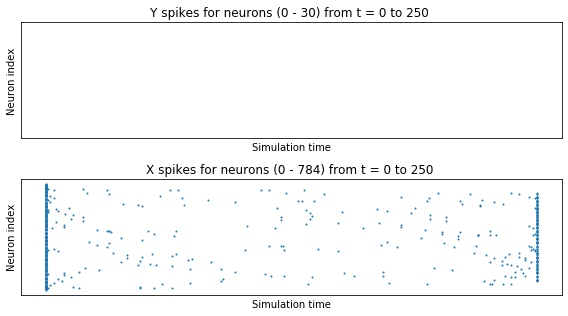

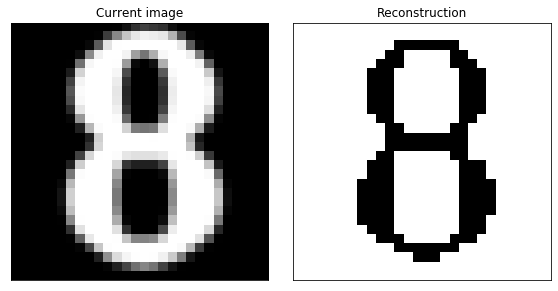

In [280]:
plot_spikes(spikes_)

from bindsnet.analysis.plotting import plot_input
plot_input(imtens[0][0],data_encod[249][0][0])




  0%|          | 0/60000 [00:00<?, ?it/s]



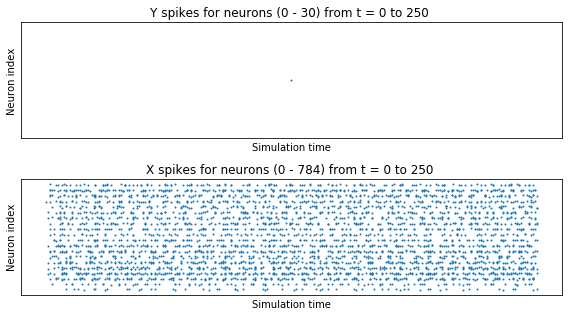

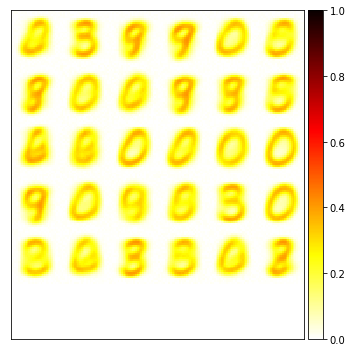

In [59]:
mnist_dataloader2 = DataLoader(
        mnist_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=n_workers,
        pin_memory=gpu,
    )

for step, batch in enumerate(tqdm(mnist_dataloader2)):
  network.learning = False
  inpts = {"X": batch["encoded_image"]}

  # Run the network on the input.
  network.run(inputs=inpts, time=time, input_time_dim=1)
  break

# Optionally plot various simulation information.
s = spikes["Y"].get("s").permute((1, 0, 2))
spike_record[
(step * batch_size)
% update_interval: (step * batch_size % update_interval)
                    + s.size(0)
] = s

    # Get voltage recording.
    #rec_voltages = rec_monitor.get("v")
    #rec_spikes = rec_monitor.get("v")

if plot:
    weights = network.connections[("X", "Y")].w
    square_weights = get_square_weights(
        weights.view(784, n_neurons), n_sqrt, 28
    )
    spikes_ = {
        layer: spikes[layer].get("s")[:, 0].contiguous() for layer in spikes
    }
    spike_ims, spike_axes = plot_spikes(spikes_)
    weights_im = plot_weights(square_weights)

    plt.pause(1e-8)

torch.Size([250, 1, 1, 28, 28])
Label 8


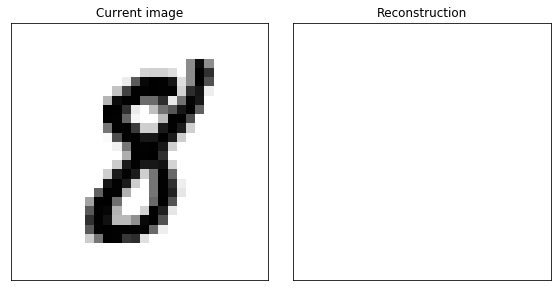

In [78]:
from bindsnet.analysis.plotting import plot_input

print(batch['encoded_image'].size())

plot_input(batch['image'][0][0],batch['encoded_image'][0][0][0])
print("Label %d"%batch['label'])

In [0]:
batch8 = batch

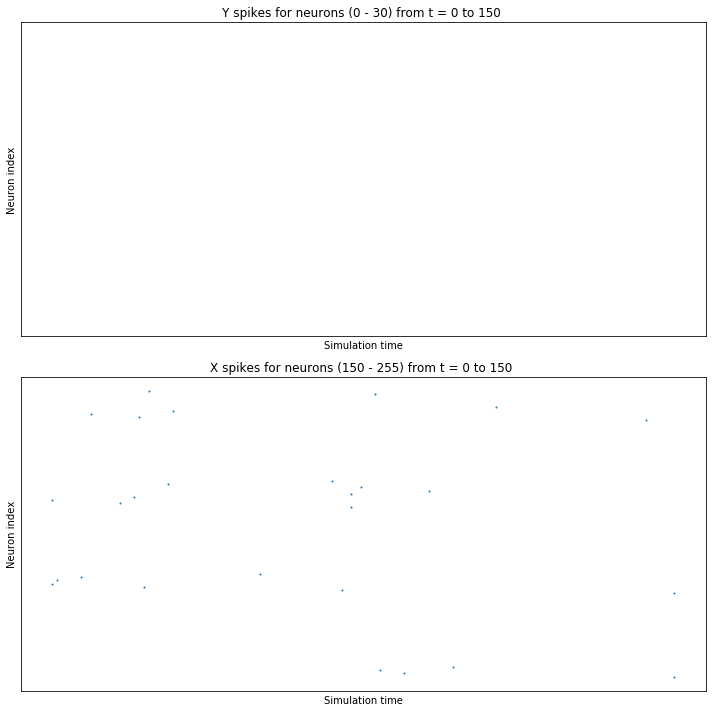

In [412]:
def Affichage(spk, temps : list, neur, figsiz : list, ATe):
  spike_ims, spike_axes = plot_spikes(spike, time=temps, n_neurons= neur, figsize= figsiz)


spk = spikes_
temps = [0, 150]
ATe = [150, 255]
neur = {'X' : ATe , 'Y' : [0, 30]}
figsiz = [10, 10]
Affichage(spike, temps, neur, figsiz, ATe)


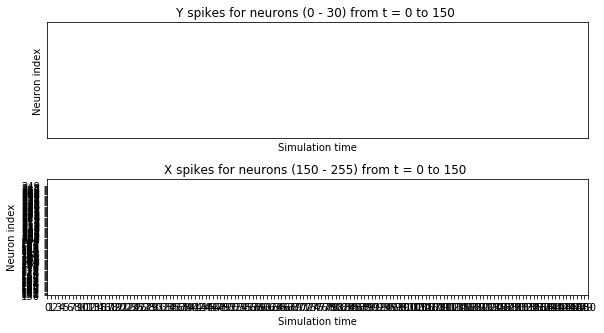

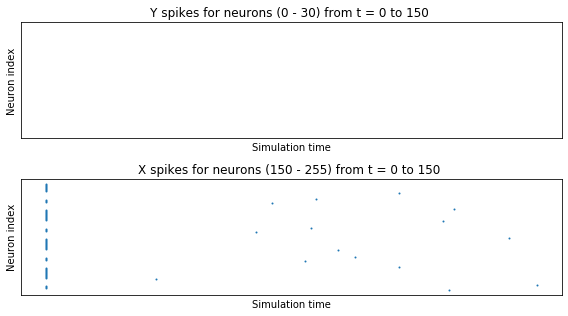

In [413]:
plot_spikes(spikes_, time=temps, n_neurons= neur)

locs, labels = plt.xticks()
locs, labels = plt.yticks()
plt.xticks(range(time))
plt.yticks(range(time))
axe = plt.gca()
axe.set_xlim(temps)
axe.set_ylim(ATe)

spike_ims, spike_axes = plot_spikes(spikes_, time=temps, n_neurons= neur)
